# Eigenfaces 🎭
## By Rohan Naphade and Nir Pechuk
Follow along to see how we can use PCA to perform unconstrained facial recognition!

# Initial Walkthrough

First, we go through the training and classification steps for a fixed matching algorithm and dimensionality reduction, allowing us to establish the techniques of Eigenfaces.

## Step 1: Load data

In [ ]:
import kagglehub

def image_to_vector(path):
    gray = Image.open(path).convert("L")
    arr = np.array(gray, dtype=np.float32)
    return arr.flatten()

# Download our dataset
# https://www.kaggle.com/datasets/sheikhazhanmohammed/celebrities-face-dataset-small?resource=download
path = kagglehub.dataset_download("sheikhazhanmohammed/celebrities-face-dataset-small") + "/Dataset"

print(path)

100%|██████████| 3.24M/3.24M [00:00<00:00, 3.70MB/s]

Extracting files...
/root/.cache/kagglehub/datasets/sheikhazhanmohammed/celebrities-face-dataset-small/versions/2/Dataset


In [ ]:
from PIL import Image
import os
import numpy as np

train_images = []
train_labels = []
test_images = []
test_labels = []

folders = sorted(os.listdir(path))

for _, folder in enumerate(folders):
  person = os.path.join(path, folder)
  if not os.path.join(person):
    continue
  for im_num, im_name in enumerate(sorted(os.listdir(person))):
    img_path = os.path.join(person, im_name)
    if (im_num == 0):
      test_images.append(image_to_vector(img_path)[:44000])
      test_labels.append(folder)
    else:
      train_images.append(image_to_vector(img_path)[:44000])
      train_labels.append(folder)

X_train_uncentered = np.vstack(train_images)
y_train = np.array(train_labels)
X_test_uncentered = np.vstack(test_images)
y_test = np.array(test_labels)

## Step 2: Mean-center Data



In [ ]:
m = np.mean(X_train_uncentered, axis=0)
X_train = X_train_uncentered - m
X_test = X_test_uncentered - m

Let's print the "average face," along with some faces before/after mean-centering!

Average Face: 


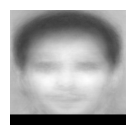

Ahn Bo Hyun's uncentered face:


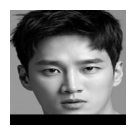

Ahn Bo Hyun's centered face:


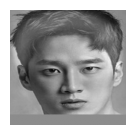

In [ ]:
import matplotlib.pyplot as plt

def show_gray_vector(vec, height=220, width=220, normalize=True):
    v = np.asarray(vec, dtype=np.float32).ravel()
    target_len = height * width

    # If truncated, pad with zeros at the end
    if v.size < target_len:
        v = np.pad(v, (0, target_len - v.size), mode='constant')
    # If somehow longer, cut off the extra tail
    elif v.size > target_len:
        v = v[:target_len]

    img = v.reshape((height, width))

    # Normalization to [0, 1] for nicer display
    if normalize:
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            img = (img - vmin) / (vmax - vmin)

    plt.figure(figsize=(1.5,1.5))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

print("Average Face: ")
show_gray_vector(m);
for i in range(1): # Change if you want to see more
  print(f"{y_test[i]}'s uncentered face:")
  show_gray_vector(X_test_uncentered[i])
  print(f"{y_test[i]}'s centered face:")
  show_gray_vector(X_test[i])

## Step 3: Perform a PCA to find Top-K Variance Dimensions

In [ ]:
U, S, Vt = np.linalg.svd(X_train, full_matrices=False)
k = 7
W = (Vt[:k, :]).T

What do our newly-found "eigenfaces" look like? What are the main "sources of variance" for these faces?

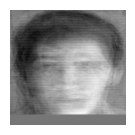

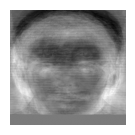

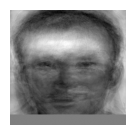

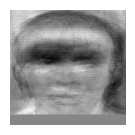

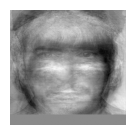

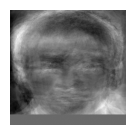

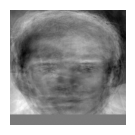

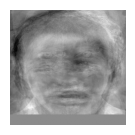

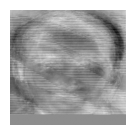

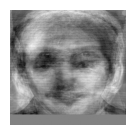

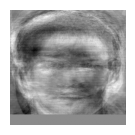

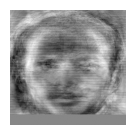

In [ ]:
for i in range(len(W[0])):
  show_gray_vector(W[:, i])

## Step 4: Convert Data to Least Squares Projection Onto Subspace Using the Pseudoinverse

In [ ]:
X_train_proj = np.linalg.pinv(W) @ X_train.T
X_test_proj = np.linalg.pinv(W) @ X_test.T
print(X_train_proj.shape)
print(X_test_proj.shape)

(7, 124)
(7, 14)


What have we lost? Let's try to reconstruct a face and compare! The original projection is called the *Forward Projection* and this process is *Backwards Projection*.

Original for Ahn Bo Hyun


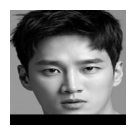

Reconstructed for Ahn Bo Hyun


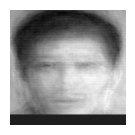

Original for Benedict Cumberbatch


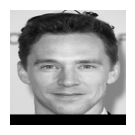

Reconstructed for Benedict Cumberbatch


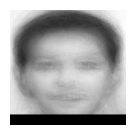

Original for Cillian Murphy


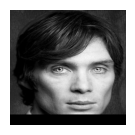

Reconstructed for Cillian Murphy


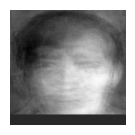

Original for Daniel Gillies


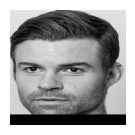

Reconstructed for Daniel Gillies


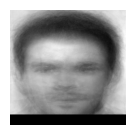

Original for Harry Styles


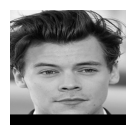

Reconstructed for Harry Styles


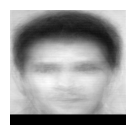

Original for Hyun Bin


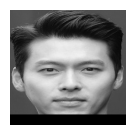

Reconstructed for Hyun Bin


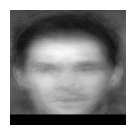

Original for Ji Chang Wook


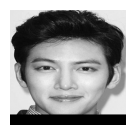

Reconstructed for Ji Chang Wook


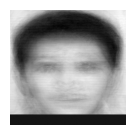

Original for Joseph Morgan


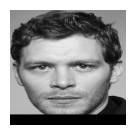

Reconstructed for Joseph Morgan


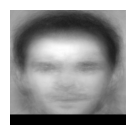

Original for Mark Zukerberg


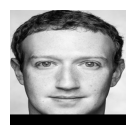

Reconstructed for Mark Zukerberg


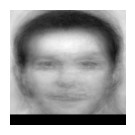

Original for Paul Wesley


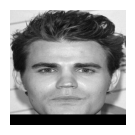

Reconstructed for Paul Wesley


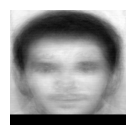

Original for Robert Jr


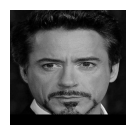

Reconstructed for Robert Jr


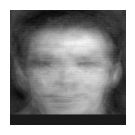

Original for Song Joong Ki


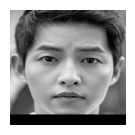

Reconstructed for Song Joong Ki


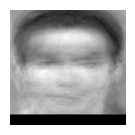

Original for Tom Hiddleston


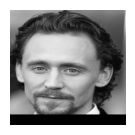

Reconstructed for Tom Hiddleston


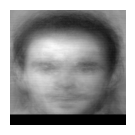

Original for Zayn Malik


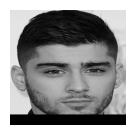

Reconstructed for Zayn Malik


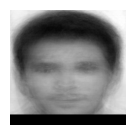

In [ ]:
# X_train_recon = (W @ X_train_proj).T + m
X_test_recon  = (W @ X_test_proj).T  + m
for i in range(X_test_recon.shape[0]):
  print(f"Original for {y_test[i]}")
  show_gray_vector(X_test_uncentered[i])
  print(f"Reconstructed for {y_test[i]}")
  show_gray_vector(X_test_recon[i])

## Step 5: Test Accuracy by Classifying Test Data!

In [ ]:
# Classify based on smallest norm and the associated label
def closest_column(x, train):
    x = np.asarray(x).reshape(-1, 1)
    diffs = train - x
    dists = np.linalg.norm(diffs, axis=0)
    return np.argmin(dists)

# Loop through test images
correct = 0
for i in range(len(X_test_proj[0])):
  classification = y_train[closest_column(X_test_proj[:, i], X_train_proj)]
  if (classification == y_test[i]):
    correct += 1
print(f'Total correct: {correct}. Total accuracy: {correct/len(X_test_proj[0])}')

# Let's see the accuracy if we didn't use this technique
correct = 0
for i in range(len(X_test_uncentered)):
  classification = y_train[closest_column(X_test_uncentered[i].T, X_train_uncentered.T)]
  if (classification == y_test[i]):
    correct += 1
print(f'Original total correct: {correct}. Original accuracy: {correct/len(X_test_uncentered)}')

Total correct: 4. Total accuracy: 0.2857142857142857
Original total correct: 4. Original accuracy: 0.2857142857142857


Hmmm, so although our new method is much more efficient (it takes less than 10% of the computation!), it doesn't show any gains in accuracy. Can we change that by optimizing our algorithm and increasing the size of our dataset?

# Hyperparameter Optimization

Let's repeat the steps, but start with a dataset much larger than before. We'll start with steps 1-3.

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
import numpy as np
from PIL import Image

# Load the csv of file names and frequencies
csv_path = "lfw_allnames.csv"
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "jessicali9530/lfw-dataset",
  path=csv_path
)
# Sort the csv by number of images per face
df.sort_values(by=['images'], inplace=True, ascending=False)
# We want each face to have at least 10 samples, and we'll take only 10 from
# each to ensure we don't overfit to more common faces. This yields
# 1580 images of 158 individuals.
df = df[df['images'] >= 10]

def image_to_vector(path, width, height):
    gray = Image.open(path).convert("L")
    # optimization: crop to the center to make the face more prominent
    # 150 pixels width and 200 pixels height
    w, h = gray.size
    cropped = gray.crop((
        (w - width) // 2,
        (h - height) // 2,
        (w + width) // 2,
        (h + height) // 2
    ))
    arr = np.array(cropped, dtype=np.float32)
    return arr.flatten()

height, width = 165, 140
train_images = []
train_labels = []
test_images = []
test_labels = []
data_path = kagglehub.dataset_download("jessicali9530/lfw-dataset") + "/lfw-deepfunneled/lfw-deepfunneled/"
# Perform the same process as earlier to convert to train and test matrices
for _, row in df.iterrows():
  for i in range(1, 11):
    img_path = data_path + \
                    row['name'] + "/" + row['name'] + \
                    "_" + f"{i:04d}" + ".jpg"
    if (i == 1):
      test_images.append(image_to_vector(img_path, width, height))
      test_labels.append(row['name'])
    else:
      train_images.append(image_to_vector(img_path, width, height))
      train_labels.append(row['name'])

X_train_uncentered = np.vstack(train_images)
y_train = np.array(train_labels)
X_test_uncentered = np.vstack(test_images)
y_test = np.array(test_labels)

Using Colab cache for faster access to the 'lfw-dataset' dataset.
Using Colab cache for faster access to the 'lfw-dataset' dataset.


In [ ]:
# Mean-center and get SVD
m = np.mean(X_train_uncentered, axis=0)
X_train = X_train_uncentered - m
X_test = X_test_uncentered - m
U, S, Vt = np.linalg.svd(X_train, full_matrices=False)

Now, there are two hyperparameters we can test. First, we see which dimensionality performs best.

## Dimensionality

In [ ]:
import matplotlib.pyplot as plt
import time
import numpy as np

def closest_column(x, train):
    x = np.asarray(x).reshape(-1, 1)
    diffs = train - x
    dists = np.linalg.norm(diffs, axis=0)
    return np.argmin(dists)

k_values = []
accuracies = []
times = []
efficiency = []

# Accuracy for each k
for k in range(5, 100, 5):
    start = time.time()

    k_values.append(k)
    W = (Vt[:k, :]).T
    Wpinv = np.linalg.pinv(W)
    X_train_proj = Wpinv @ X_train.T
    X_test_proj = Wpinv @ X_test.T

    correct = 0
    for i in range(len(X_test_proj[0])):
        classification = y_train[closest_column(X_test_proj[:, i], X_train_proj)]
        if classification == y_test[i]:
            correct += 1

    acc = (correct / len(X_test_proj[0])) * 100
    accuracies.append(acc)

    end = time.time()

    elapsed = end - start
    times.append(elapsed)
    efficiency.append(acc / elapsed)

# Non-PCA Method
start = time.time()

correct = 0
for i in range(len(X_test_uncentered)):
    classification = y_train[closest_column(X_test_uncentered[i].T, X_train_uncentered.T)]
    if classification == y_test[i]:
        correct += 1

y = (correct / len(X_test_uncentered)) * 100

original_time = time.time() - start
original_efficiency = y / original_time

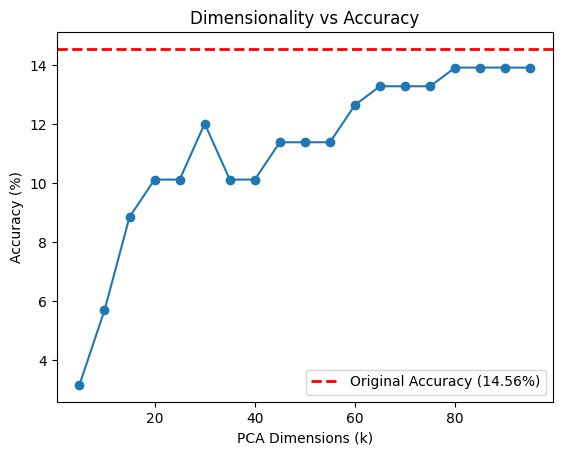

/tmp/ipython-input-210449472.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


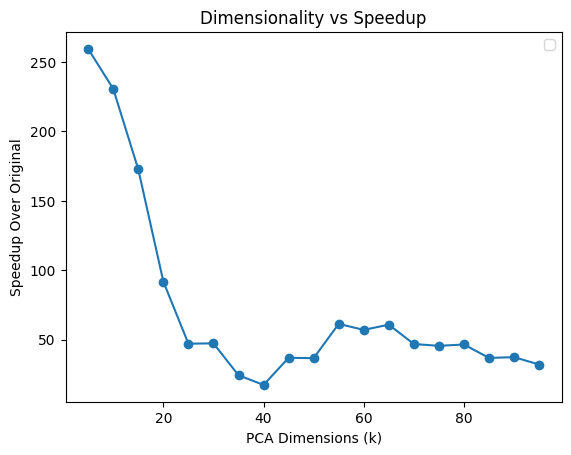

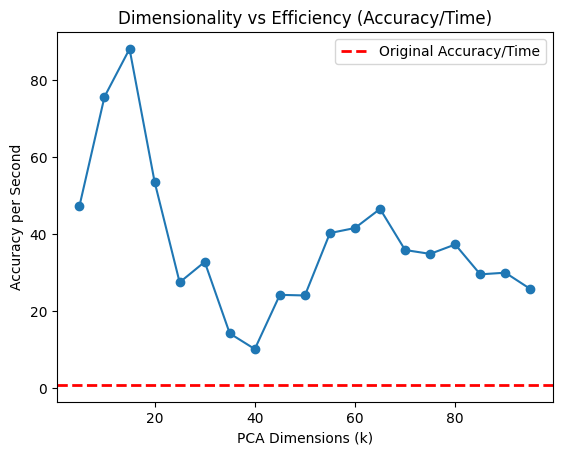

In [ ]:
# Accuracy Graph
plt.plot(k_values, accuracies, marker='o')
plt.axhline(y, color='red', linestyle='--', linewidth=2,
            label=f"Original Accuracy ({y:.2f}%)")
plt.xlabel("PCA Dimensions (k)")
plt.ylabel("Accuracy (%)")
plt.title("Dimensionality vs Accuracy")
plt.legend()
plt.show()

# Speedup Graph
speedups = []
for i in range(len(times)):
  speedups.append(original_time / times[i])
plt.plot(k_values, speedups, marker='o')
plt.xlabel("PCA Dimensions (k)")
plt.ylabel("Speedup Over Original")
plt.title("Dimensionality vs Speedup")
plt.legend()
plt.show()

# Efficiency Graph
plt.plot(k_values, efficiency, marker='o')
plt.axhline(original_efficiency, color='red', linestyle='--', linewidth=2,
            label="Original Accuracy/Time")
plt.xlabel("PCA Dimensions (k)")
plt.ylabel("Accuracy per Second")
plt.title("Dimensionality vs Efficiency (Accuracy/Time)")
plt.legend()
plt.show()

Next, we'll fix k = 80 (the optimal dimensionality) and focus on how many neighbors we use in our k-nearest-neighbors classification.

## Classification Algorithm

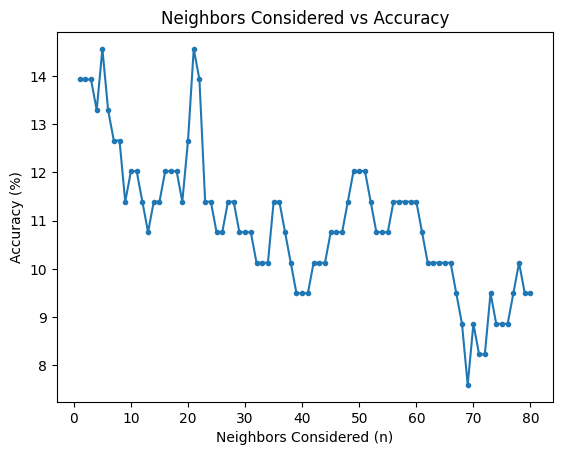

In [ ]:
from collections import defaultdict

def sorted_nearest_columns(x, train):
    x = np.asarray(x).reshape(-1,1)
    diffs = train - x
    dists = np.linalg.norm(diffs, axis=0)
    indices = np.argsort(dists)
    return indices

def majority_vote(indices, labels, k):
    votes = defaultdict(int)
    for i in range(k):
        votes[labels[indices[i]]] += 1
    return max(votes, key=votes.get)

max_considered = 80
k_values = [i for i in range(1, max_considered + 1)]
correct_count = [0] * max_considered
W = (Vt[:80, :]).T
Wpinv = np.linalg.pinv(W)
X_train_proj = Wpinv @ X_train.T
X_test_proj = Wpinv @ X_test.T

for i in range(len(X_test_proj[0])):
  for k in range(1, max_considered + 1):
    classification = majority_vote(sorted_nearest_columns(X_test_proj[:, i], X_train_proj), y_train, k)
    if classification == y_test[i]:
        correct_count[k-1] += 1

accuracy = [100 * count / len(X_test_proj[0]) for count in correct_count]

# Plot values
plt.plot(k_values, accuracy, marker='.')
plt.xlabel("Neighbors Considered (n)")
plt.ylabel("Accuracy (%)")
plt.title("Neighbors Considered vs Accuracy")
plt.show()



## Grid Search: Putting it All Together

Let's do a grid search on the most promising range; 1-30 neighbors considered and 20-90 dimensions.

Best accuracy: 14.56%
Best PCA dimensionality (k): 80
Best number of neighbors (n): 5


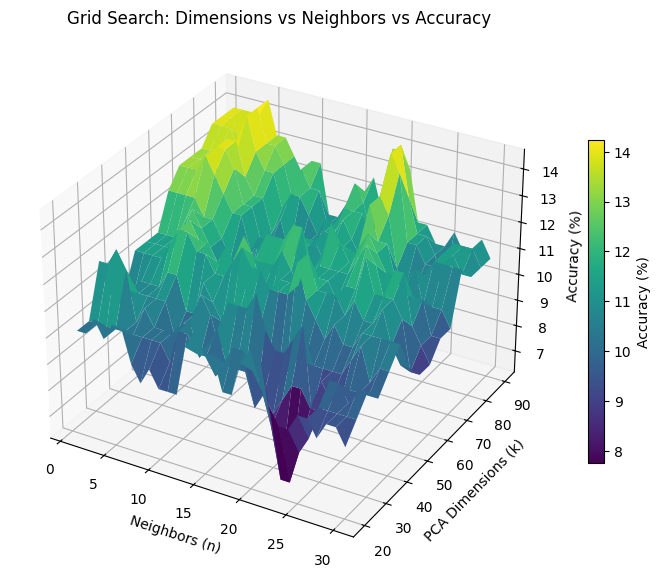

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

def sorted_nearest_columns(x, train):
    x = np.asarray(x).reshape(-1, 1)
    diffs = train - x
    dists = np.linalg.norm(diffs, axis=0)
    indices = np.argsort(dists)
    return indices

def majority_vote(indices, labels, k):
    votes = defaultdict(int)
    for i in range(k):
        votes[labels[indices[i]]] += 1
    return max(votes, key=votes.get)

dim_values = list(range(20, 91, 5))
k_values = list(range(1, 31))

accuracy_grid = np.zeros((len(dim_values), len(k_values)))  # rows: dims, cols: k

for di, dim in enumerate(dim_values):
    W = (Vt[:dim, :]).T
    Wpinv = np.linalg.pinv(W)
    X_train_proj = Wpinv @ X_train.T
    X_test_proj  = Wpinv @ X_test.T

    sorted_indices_list = []
    for j in range(X_test_proj.shape[1]):
        sorted_indices_list.append(
            sorted_nearest_columns(X_test_proj[:, j], X_train_proj)
        )

    for ki, k in enumerate(k_values):
        correct = 0
        for j, indices in enumerate(sorted_indices_list):
            pred = majority_vote(indices, y_train, k)
            if pred == y_test[j]:
                correct += 1

        acc = correct / len(y_test) * 100.0
        accuracy_grid[di, ki] = acc


best_di, best_ki = np.unravel_index(np.argmax(accuracy_grid), accuracy_grid.shape)
best_dim = dim_values[best_di]
best_k   = k_values[best_ki]
best_acc = accuracy_grid[best_di, best_ki]

print(f"Best accuracy: {best_acc:.2f}%")
print(f"Best PCA dimensionality (k): {best_dim}")
print(f"Best number of neighbors (n): {best_k}")


K, D = np.meshgrid(k_values, dim_values)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    K, D, accuracy_grid,
    cmap='viridis',
    edgecolor='none',
    antialiased=True
)

ax.set_xlabel("Neighbors (n)")
ax.set_ylabel("PCA Dimensions (k)")
ax.set_zlabel("Accuracy (%)")
ax.set_title("Grid Search: Dimensions vs Neighbors vs Accuracy")

fig.colorbar(surf, ax=ax, shrink=0.6, label="Accuracy (%)")

plt.show()

## More Visualization

There's a lot more data here, so what do some of the top eigenfaces look like now?

Average Face: 


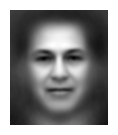

Top 20 Eigenfaces: 


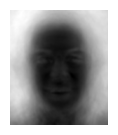

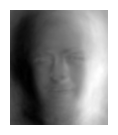

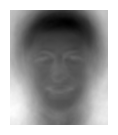

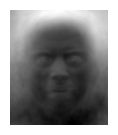

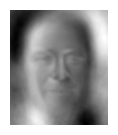

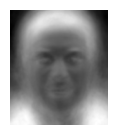

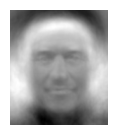

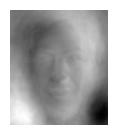

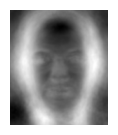

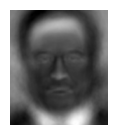

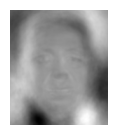

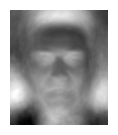

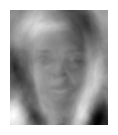

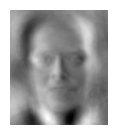

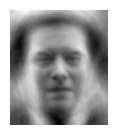

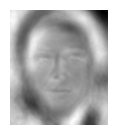

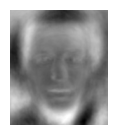

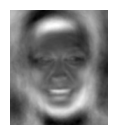

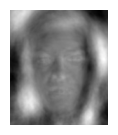

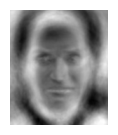

In [ ]:
# Redefining the function just in case we're only running this section
def show_gray_vector(vec, height=220, width=220, normalize=True):
    v = np.asarray(vec, dtype=np.float32).ravel()
    target_len = height * width

    # If truncated, pad with zeros at the end
    if v.size < target_len:
        v = np.pad(v, (0, target_len - v.size), mode='constant')
    # If somehow longer, cut off the extra tail
    elif v.size > target_len:
        v = v[:target_len]

    img = v.reshape((height, width))

    # Normalization to [0, 1] for nicer display
    if normalize:
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            img = (img - vmin) / (vmax - vmin)

    plt.figure(figsize=(1.5,1.5))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

# Show mean face
print("Average Face: ")
show_gray_vector(m, height, width)

# Show top 20 eigenfaces
print("Top 20 Eigenfaces: ")
for i in range(20):
  show_gray_vector(W[:, i], height, width)